In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import noisereduce as nr
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
import IPython
import os
import pyaudio
import time
from RPLCD import CharLCD
import RPi.GPIO as GPIO

lib\site-packages\noisereduce\noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
 lcd = CharLCD(numbering_mode=GPIO.BOARD, cols=16, rows=2, pin_rs=37, pin_e=35, pins_data=[40, 38, 36, 32, 33, 31, 29, 23])

In [2]:
#Load segment audio classification model

model_path = r"Dataset_audio - Copy/Models/finalfinal/"
model_name = "audio_NN_New2021_09_06_05_19_14_acc_94.01"

# Model reconstruction from JSON file
with open(model_path + model_name + '.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights(model_path + model_name + '.h5')

# Replicate label encoder
lb = LabelEncoder()
lb.fit_transform(['Baby cry','Clock Alarm', 'Glass breaking','Tap open','Door knock'])

array([0, 1, 3, 4, 2], dtype=int64)

In [3]:
#Some Utils

# Plot audio with zoomed in y axis
def plotAudio(output):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10))
    plt.plot(output, color='blue')
    ax.set_xlim((0, len(output)))
    ax.margins(2, -0.1)
    plt.show()

# Plot audio
def plotAudio2(output):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    plt.plot(output, color='blue')
    ax.set_xlim((0, len(output)))
    plt.show()

def minMaxNormalize(arr):
    mn = np.min(arr)
    mx = np.max(arr)
    return (arr-mn)/(mx-mn)

def predictSound(X):
    clip, index = librosa.effects.trim(X, top_db=20, frame_length=512, hop_length=64) 
    stfts = np.abs(librosa.stft(clip, n_fft=512, hop_length=256, win_length=512))
    stfts = np.mean(stfts,axis=1)
    stfts = minMaxNormalize(stfts)
    result = model.predict(np.array([stfts]))
    predictions = [np.argmax(y) for y in result]
    result1 = lb.inverse_transform([predictions[0]])[0]
    lcd.clear()
    lcd.cursor_pos = (0, 0)
    lcd.write_string("Sound Detected :\n\r")
    lcd.cursor_pos = (1, 0)
    lcd.write_string(result1 + " \n" )
    print(result1)
    plotAudio2(clip)
    

Noise Sample


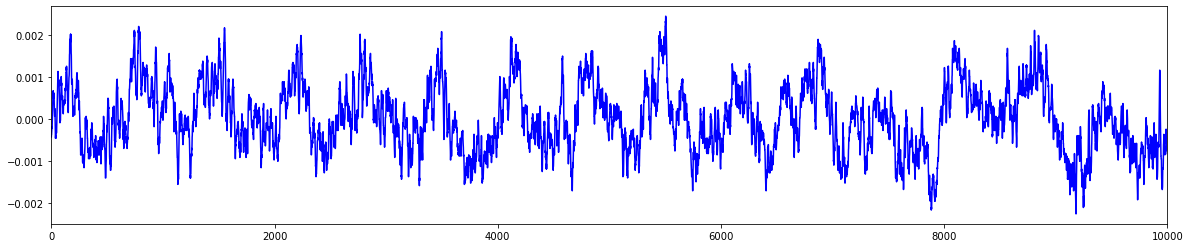

Loud threshold 0.06328094750642776


<ipython-input-4-1466a38403fd>:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(audio_buffer==[]):


Inside silence reign
Inside silence reign
Inside silence reign
Inside silence reign
Inside silence reign
Inside silence reign
Inside silence reign
Inside silence reign
Inside silence reign
Inside silence reign
Inside silence reign
Door knock


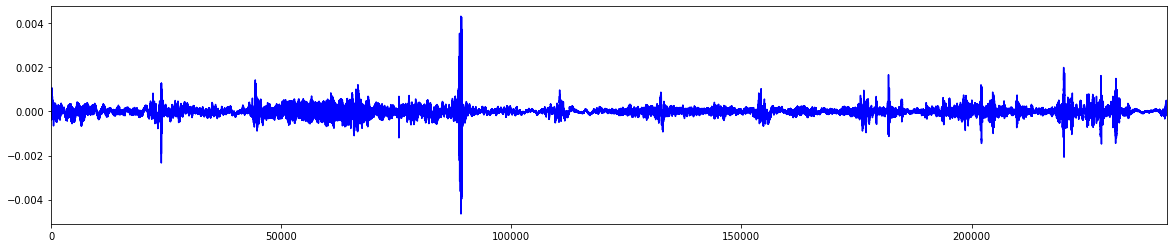

Inside silence reign
Tap open


<ipython-input-4-1466a38403fd>:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(audio_buffer==[]):


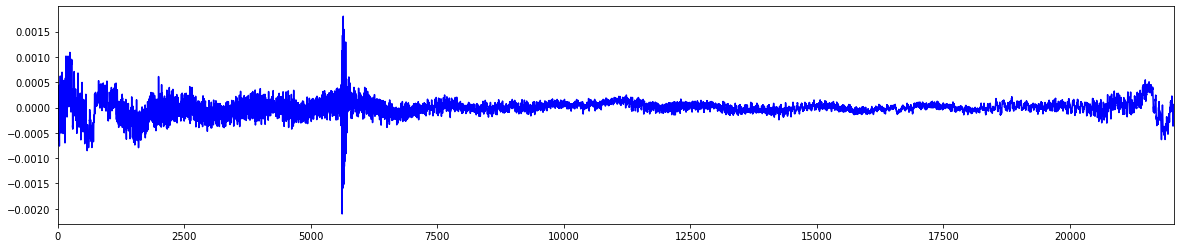

<ipython-input-4-1466a38403fd>:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(audio_buffer==[]):


Inside silence reign
Tap open


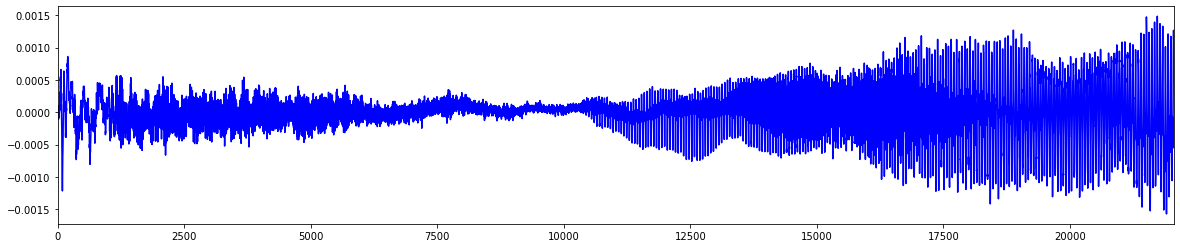

KeyboardInterrupt: 

In [4]:
CHUNKSIZE = 22050 
RATE = 22050

p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)

data = stream.read(10000)
noise_sample = np.frombuffer(data, dtype=np.float32)
print("Noise Sample")
plotAudio2(noise_sample)
loud_threshold = np.mean(np.abs(noise_sample)) * 100
print("Loud threshold", loud_threshold)
audio_buffer = []
near = 0

while(True):
    time.sleep(5)
    
    data = stream.read(CHUNKSIZE)
    current_window = np.frombuffer(data, dtype=np.float32)
    
    current_window = nr.reduce_noise(audio_clip=current_window, noise_clip=noise_sample, verbose=False)
    
    if(audio_buffer==[]):
        audio_buffer = current_window
    else:
        if(np.mean(np.abs(current_window))<loud_threshold):
            print("Inside silence reign")
            if(near<10):
                audio_buffer = np.concatenate((audio_buffer,current_window))
                near += 1
            else:
                predictSound(np.array(audio_buffer))
                audio_buffer = []
                near
        else:
            print("Inside loud reign")
            near = 0
            audio_buffer = np.concatenate((audio_buffer,current_window))


stream.stop_stream()
stream.close()
p.terminate()
